In [493]:
# general imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import geopandas as gpd
import getpass
import ast
import numpy as np

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests

# geometry and rasterio imports
from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import transform as shapely_transform
from shapely.wkt import loads
from pyproj import Geod
from functools import partial

from pyproj import Transformer

from rasterio.io import MemoryFile
import rasterio.merge
import rasterio
import rasterio.plot
from rasterio.plot import show
from rasterio.mask import mask

from rasterio.transform import array_bounds, from_bounds, xy

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# pytorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm

In [494]:
# loads the dataset
all_gdf = pd.read_csv(r'C:\Users\richard.smith\OneDrive - MAPP LTD\Desktop\VM Desktop\Python Jupyter Notebooks\Eurosat Training\all_gdf.csv')

In [495]:
all_gdf.head()

geo_labelw        geo_label   geo_code  \
0        NaN   South Ayrshire  S12000028   
1        NaN  Huntingdonshire  E07000011   
2        NaN       Tewkesbury  E07000083   
3        NaN  West Lancashire  E07000127   
4        NaN       Darlington  E06000005   

                                            geometry  \
0  MULTIPOLYGON (((244282.59999999963 632703.5999...   
1  MULTIPOLYGON (((511946.215 290765.599, 511942....   
2  POLYGON ((378940.315 221169.788, 378941.813 22...   
3  MULTIPOLYGON (((332523.5 410159.094, 332517.72...   
4  POLYGON ((423801.813 514513.5, 423780.596 5145...   

                                        new_geometry  \
0  POLYGON ((244282.59999999963 632703.5999999996...   
1  POLYGON ((511946.215 290765.599, 511942.906 29...   
2  POLYGON ((378940.315 221169.788, 378941.813 22...   
3  POLYGON ((332523.5 410159.094, 332517.724 4101...   
4  POLYGON ((423801.813 514513.5, 423780.596 5145...   

                                    aoi_coords_wgs84      aoi_size  
0  [-5.0606574611546895, 54.997783671505985, -4.3...  (4368, 6617)  
1  [-0.49990712939176263, 52.15872374092071, 0.05...  (3570, 4865)  
2  [-2.352748969913588, 51.81930310549422, -1.801...  (3756, 2620)  
3  [-3.046701000153703, 53.48276587692606, -2.689...  (2359, 2798)  
4  [-1.7097551016536965, 54.45112626483218, -1.40...  (1918, 1912)

In [496]:
gdf_head = all_gdf.head()

gdf_head.to_csv('gdf_head.csv',index=False)

In [497]:
all_gdf.shape[0]

404

In [498]:
gdf_head_test = pd.read_csv(r"C:\Users\richard.smith\OneDrive - MAPP LTD\Desktop\VM Desktop\Python Jupyter Notebooks\Eurosat Training\Project_Files\gdf_head.csv")

In [499]:
gdf_head_test.tail(3)

geo_labelw        geo_label   geo_code  \
2         NaN       Tewkesbury  E07000083   
3         NaN  West Lancashire  E07000127   
4         NaN       Darlington  E06000005   

                                            geometry  \
2  POLYGON ((378940.315 221169.788, 378941.813 22...   
3  MULTIPOLYGON (((332523.5 410159.094, 332517.72...   
4  POLYGON ((423801.813 514513.5, 423780.596 5145...   

                                        new_geometry  \
2  POLYGON ((378940.315 221169.788, 378941.813 22...   
3  POLYGON ((332523.5 410159.094, 332517.724 4101...   
4  POLYGON ((423801.813 514513.5, 423780.596 5145...   

                                    aoi_coords_wgs84      aoi_size  
2  [-2.352748969913588, 51.81930310549422, -1.801...  (3756, 2620)  
3  [-3.046701000153703, 53.48276587692606, -2.689...  (2359, 2798)  
4  [-1.7097551016536965, 54.45112626483218, -1.40...  (1918, 1912)

In [500]:
# map geometrys back to Polygon object as its saved as str

def str_to_polygon(polygon_str):
    # if not polygon_str.endswith('))'):
    #     polygon_str += '))'
    return loads(polygon_str)
    
all_gdf['new_geometry'] = all_gdf['new_geometry'].apply(str_to_polygon)

In [501]:
filtered_gdf = all_gdf[all_gdf['geo_label'] == 'Coventry'] # filters to authority

# gets coord of filtered line
aoi_coord = filtered_gdf.iloc[0].aoi_coords_wgs84 # gets polygon

# currently in a str this covnerts to list
aoi_coord = ast.literal_eval(aoi_coord) # converts string to list

# gets polygon coord to use later (when overlaying polygon onto boundary image
polygon_coord = filtered_gdf.iloc[0].new_geometry

In [503]:
aoi_coord

[-1.6144590693891865,
 52.36387600807079,
 -1.4239382735936605,
 52.46478728324638]

# Processing images too large for one bbox

some of the authorities have bounding boxes much larger than the sentine API accepts

### Using Rasterio to process images

https://rasterio.readthedocs.io/en/stable/index.html

https://medium.com/@mommermiscience/dealing-with-geospatial-raster-data-in-python-with-rasterio-775e5ba0c9f5

In [504]:
# config details for Sentinel hub

config = SHConfig()
#config.sh_client_id = 'sh-b722cd55-824c-44e8-afa3-e53e5db1dd27'
#config.sh_client_secret = 'nAFu1yfyPGsQWD76IJDv8fbNhxPY9diz'

# richesmith@hotmail.com
# config.sh_client_id = '2589f2ec-6249-4d95-867c-450a7d83be80'
# config.sh_client_secret = 'clgiyt8zfqPrHAoLSLSKry1wNU26WQGd'

#richesmith@me.com
client_id = '3a02d69f-c41d-4611-9d93-4584df5e3402'
client_secret = '7xKntAAXf1mU3tKPgsHTlbd9XaN45NYU'

#https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token
#config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

config.sh_token_url = "https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

## Converts bounding box to meters from degrees here

I think this is so they can be stitched together properly


In [505]:
# splitting the bounding box
# the function splits the bounding box up if it exceeds the max pixels the API will allow (2500) either in width and/or height
# returns as list of boudning boxes and the size for using when stitching back together

# used a few places for help with this...
# https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html
# https://pyproj4.github.io/pyproj/stable/api/geod.html

def split_bounding_box(coords, max_pixels, resolution=10):

    minx, miny, maxx, maxy = coords # gets each piece from the bounding box coords

    # calculates the bounding box width and height in meters as it is in degrees
    # converts degrees to meters
    geod = Geod(ellps="WGS84")
    width = geod.inv(minx, miny, maxx, miny)[2]  # distance between minx and maxx at miny
    height = geod.inv(minx, miny, minx, maxy)[2]  # distance between miny and maxy at minx

    # calculate width/height in pixels
    width_pixels = width / resolution
    height_pixels = height / resolution

    # split into tiles if dimensions exceed max_pixels (2500)
    x_splits = int(np.ceil(width_pixels / max_pixels))
    y_splits = int(np.ceil(height_pixels / max_pixels))

    x_step = (maxx - minx) / x_splits
    y_step = (maxy - miny) / y_splits

    tiles = [] #list to hold tiles
    for i in range(x_splits):
        for j in range(y_splits):
            tile_minx = minx + i * x_step
            tile_miny = miny + j * y_step
            tile_maxx = tile_minx + x_step
            tile_maxy = tile_miny + y_step

            # calculates pixel size for this tile
            tile_width_pixels = int(width_pixels / x_splits)
            tile_height_pixels = int(height_pixels / y_splits)

            # appends bounding box and pixel size to list
            tiles.append(([tile_minx, tile_miny, tile_maxx, tile_maxy], (tile_width_pixels, tile_height_pixels)))

    return tiles # retunrs the list of tiles

In [507]:
# help from here...
# https://docs.authlib.org/en/latest/client/oauth2.html

# Your client credentials
client_id = '2589f2ec-6249-4d95-867c-450a7d83be80'
client_secret = 'clgiyt8zfqPrHAoLSLSKry1wNU26WQGd'

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# Change from l12a to l12c

## 2c

In [509]:
def request_tile_rasterio(tile_coords, tile_size, access_token):

    # adds timeframe for requestion images
    time_from = "2022-05-01T00:00:00Z"
    time_to   = "2022-07-30T23:59:59Z"
    mosaicking_order = "leastCC"
    max_cc = 70

    # API request body
    width, height = tile_size
    request_payload = {
        "input": {
            "bounds": {
                "bbox": tile_coords,
                "properties": {
                    # defines CRS as WGS84
                    "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
                }
            },
            "data": [
                {
                    "type": "sentinel-2-l1c",  # uses sentinel 2c
                    "dataFilter": {
                        "timeRange": {
                            "from": time_from,
                            "to": time_to
                        },
                        "mosaickingOrder": mosaicking_order,
                        "maxCloudCoverage": max_cc
                    }
                }
            ]
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [
                {
                    "identifier": "default",
                    "format": {"type": "image/tiff"}
                }
            ]
        },
        "evalscript": """
        //VERSION=3
        function setup() {
          return {
            input: [ "B02", "B03", "B04" ],
            output: { bands: 3 }
          };
        }
        function evaluatePixel(sample) {
          return [sample.B04, sample.B03, sample.B02];  // RGB
        }
        """
    }

    # headers
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Accept": "image/tiff"
    }

    # make API call
    response = requests.post(
        "https://services.sentinel-hub.com/api/v1/process",
        json=request_payload,
        headers=headers
    )

    # check for errors
    if response.status_code != 200:
        raise RuntimeError(
            f"Request failed with status {response.status_code}: {response.text}"
        )

    # convert response to a raster memory file
    raw_tiff = response.content
    memfile = MemoryFile(raw_tiff)

    return memfile

In [510]:
# stitching tiles
#uses merge function ro merge the memeoryfile objects into a single image - it retains the geospatial positioning
# https://rasterio.readthedocs.io/en/stable/api/rasterio.merge.html

def stitch_tiles_rasterio(tile_memfiles):

    datasets = [rasterio.open(memfile) for memfile in tile_memfiles]
    mosaic, transform = rasterio.merge.merge(datasets)

    # clean up memory
    for dataset in datasets:
        dataset.close()

    return mosaic, transform

In [511]:
# combining functions
# splits bounding box, requests tiles, stitches together (retains geospatial data

# https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html

def process_large_bounding_box_rasterio(coords, max_pixels=2500, resolution=10):
    tiles_coords_and_sizes = split_bounding_box(coords, max_pixels, resolution)

    # requests all tiles
    tile_memfiles = [
        request_tile_rasterio(tile[0], tile[1], token['access_token']) for tile in tiles_coords_and_sizes
    ]

    # stitch tiles together
    stitched_image, transform = stitch_tiles_rasterio(tile_memfiles)

    return stitched_image, transform

In [512]:
# request images for each tile

tiles_coords_and_sizes = split_bounding_box(aoi_coord, max_pixels=2500, resolution=10)

print(tiles_coords_and_sizes)

[([-1.6144590693891865, 52.36387600807079, -1.4239382735936605, 52.46478728324638], (1297, 1122))]


In [514]:
# plots image

def display_image(image_array):
    # changes array from channel-first format to channel-last format
    # raster file saves as chanell forsit but matplotlib needs chanelle first
    if image_array.shape[0] <= 4:  # Assuming 3 or 4 channels (RGB or RGBA)
        image_array = np.transpose(image_array, (1, 2, 0))  # (C, H, W) -> (H, W, C)

    # Normalize pixel values to [0, 1] if they exceed 1
    if image_array.max() > 1:
        image_array = image_array / 255.0

    plt.figure(figsize=(10, 10))
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()

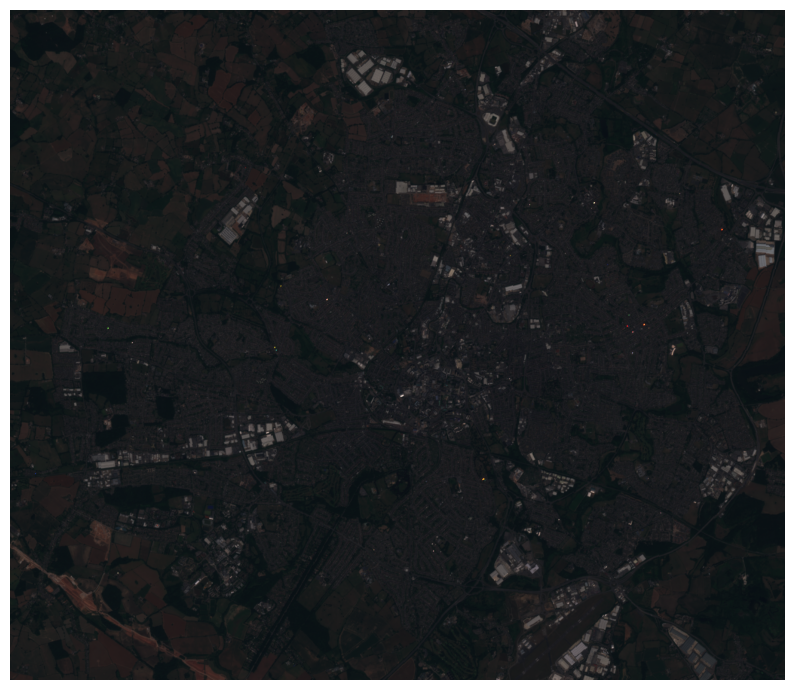

In [515]:
# runs function to get image data
stitched_image, transform = process_large_bounding_box_rasterio(aoi_coord, max_pixels=2500, resolution=10)
#save_stitched_image("Coventry_rasterio.tif", stitched_image, transform)
display_image(stitched_image)

In [516]:
float_image = stitched_image / 255.0
mean_val = float_image.mean()
print("Mean brightness:", mean_val)

Mean brightness: 0.10541275391408643


### enhance image

In [517]:
# the images coming through from the sentinel hub where very dark, this enhances them so they match the Eurosat images
# percentile stretch improves brightness and contrast by remapping pixel values

# https://scikit-image.org/docs/0.9.x/auto_examples/plot_equalize.html
# https://medium.com/data-caffeine/enhance-your-image-in-three-ways-in-python-7246a7b6bd66
#https://stackoverflow.com/questions/60449340/contrast-enhancement-using-a-percentage-cumulative-count-in-matplolib


# low_percent=2, high_percent=98 gave quite high contrast
# 5,98 no different really, keep experimenting
def percentile_stretch(image_array, low_percent=2, high_percent=98):
    # this reshapes to the correct channels so to compute percentiles
    if image_array.ndim == 3 and image_array.shape[0] < 10:
        # likely returned shape is (C, H, W)
        # transpose to (H, W, C)
        image_reshaped = np.transpose(image_array, (1, 2, 0))
        channel_first = True
    else:
        image_reshaped = image_array
        channel_first = False

    # flattens each channel separately
    c = image_reshaped.shape[2] if image_reshaped.ndim == 3 else 1
    
    # hold results in the same shape
    stretched_image = np.zeros_like(image_reshaped)

    for ch in range(c):
        # extract channel
        channel_data = image_reshaped[..., ch].flatten()
        
        # compute percentiles
        p_low_val = np.percentile(channel_data, low_percent)
        p_high_val = np.percentile(channel_data, high_percent)

        # stretch channel, clamp and scale
        out_channel = image_reshaped[..., ch]
        out_channel = np.clip(out_channel, p_low_val, p_high_val)
        out_channel = (out_channel - p_low_val) / (p_high_val - p_low_val + 1e-8)
        
        stretched_image[..., ch] = out_channel

    # if channel_first, transpose back
    if channel_first:
        stretched_image = np.transpose(stretched_image, (2, 0, 1))

    return stretched_image

# use function and apply
float_image = stitched_image / 255.0
enhanced_image = percentile_stretch(float_image, low_percent=0.2, high_percent=99.8)



display_image(enhanced_image)

## overlaying the polygon bounds onto the image

In [523]:
# creates polygon from polygon_coord variable
polygon = Polygon(polygon_coord)

# defines the crs being used 
raster_crs = "EPSG:4326"  # raster is in WGS84
polygon_crs = "EPSG:27700"  # the crs the polygon is currently in

In [524]:
# computes rater bounds gives geographic extent of the raster in [minx, miny, maxx, maxy]
raster_bounds = array_bounds(
    stitched_image.shape[1],  # height
    stitched_image.shape[2],  # width
    transform
)

# recomputes the affine transformation using the rasters actual bounds
# previous transform incoorect. COuld be because the images are being stitched together
# https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html
width, height = stitched_image.shape[2], stitched_image.shape[1]
correct_transform = from_bounds(*raster_bounds, width=width, height=height)

# creates a transformer object to convert from polygon CRS to raster CRS
transformer = Transformer.from_crs(polygon_crs, raster_crs, always_xy=True)

# reprojects the polygon into the correct crs using shapely
reprojected_polygon = shapely_transform(transformer.transform, polygon)

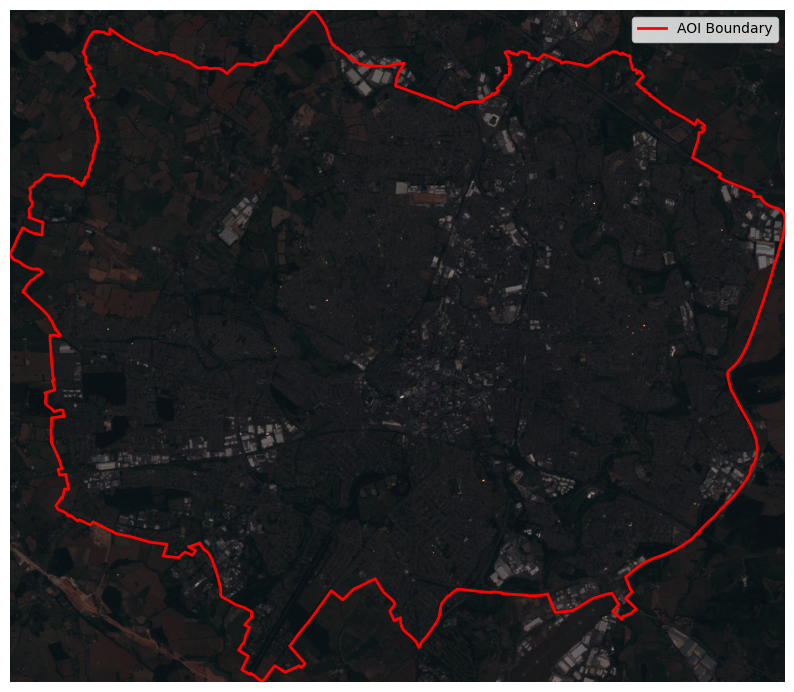

In [525]:
# plotting the raster and polygon boundary
fig, ax = plt.subplots(figsize=(10,10))

# Display the raster with the corrected transform
show(stitched_image, transform=correct_transform, ax=ax)

# Overlay the polygon boundary
x, y = reprojected_polygon.exterior.xy
ax.plot(x, y, color='red', linewidth=2, label='AOI Boundary')

# adjusts aspect ratio taking into account latitude and accounts for distortion in degrees
# needs this otherwise squashes horizontally
ax.set_aspect(1 / np.cos(np.radians(reprojected_polygon.bounds[1])))

# add legend/turn off axis
ax.legend()
plt.axis('off')
#ax.set_aspect("equal")
plt.show()

### Mask/clip and divide into grid

put this into a function

This masks the image using the polygon so areas outside are either masked or clipped

* masked if you set crop=False, this keeps the rasters original size and grid
    * if you want to retain the same spatial alignment
    * pixels inside the boundary have values, pixels outside dony
* clipped if you set crop=True
    * reduces raster size
    * improves computation efficiency

#### Use False here

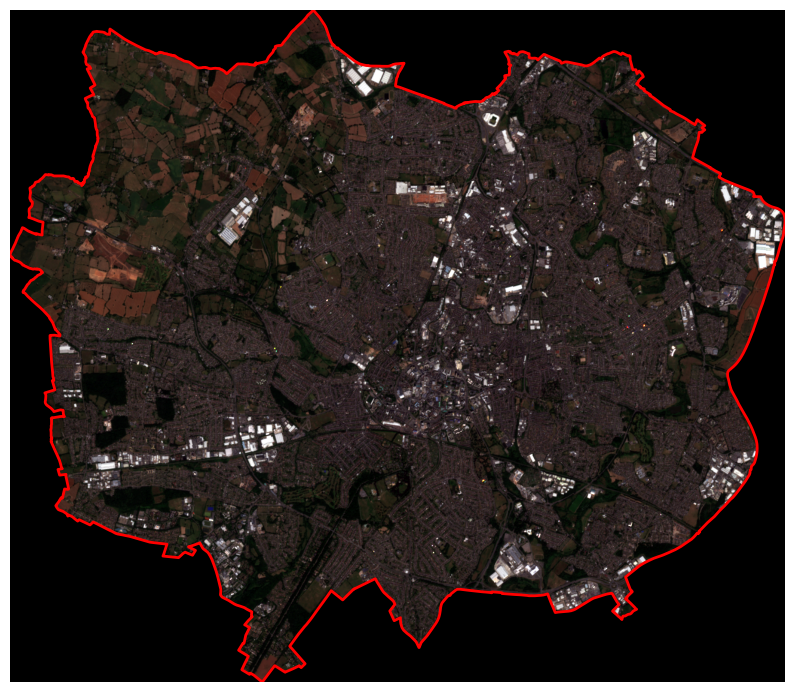

In [527]:
# the images making up the stitched_image were raster memoryfiles but after using the stitching functioin they no longer are
# it is now just a numpy array and will have loist the geospatial metadata
# so the image needs to be turned into a raster memoryfile

# create a memory file dataset from stitched_image

# dict for meta data
meta = {
    "driver": "GTiff",
    "dtype": enhanced_image.dtype,
    "count": enhanced_image.shape[0],  # num of bands
    "height": enhanced_image.shape[1],
    "width": enhanced_image.shape[2],
    "transform": correct_transform,  # both transform and correct_transform seem to do the same thing here
    "crs": "EPSG:4326",
}

with MemoryFile() as memfile:
    with memfile.open(**meta) as dataset:
        # Write each band to the dataset
        for i in range(enhanced_image.shape[0]):
            dataset.write(enhanced_image[i], i + 1)

        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html
        # mask the raster using the polygon
        masked_image, masked_transform = mask(
            dataset, shapes=[reprojected_polygon], crop=False)

# plot the masked raster
fig, ax = plt.subplots(figsize=(10, 10))
show(masked_image, transform=masked_transform, ax=ax)

# ovelay the polygon bpundary so it looks a bit clearer
x, y = reprojected_polygon.exterior.xy
ax.plot(x, y, color='red', linewidth=2, label='AOI Boundary')

# adjusts aspect ratio taking into account latitude and accounts for distortion in degrees
# needs this otherwise squashes horizontally
ax.set_aspect(1 / np.cos(np.radians(reprojected_polygon.bounds[1])))

plt.axis("off")
plt.show()

## Get total pixels and total sqkm

rasterio mask includes all pixels in the masked area even if only a fraction of the pixel is covered

In [528]:
###### Get data for pixel count and sq km
valid_pixels = np.count_nonzero(masked_image[0]) # counts non zero pixels

print(valid_pixels)

sq_km = ((valid_pixels *10) * 10)/1000000

print(sq_km)

982467
98.2467


## Divide/preprocess and predict/overlay onto map

In [529]:
# divides the image into 64x64 pixel sections (in line with Eurosat)
# it excludes patches that have too many invalid pixels - these are out of range of the masked section

# https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
# https://numpy.org/doc/2.2/reference/maskedarray.html

def split_into_sections(masked_image, mask, section_size, stride=None, threshold=0.2):
    stride = section_size if stride is None else stride
    sections = []
    coordinates = []
    
    channels, height, width = masked_image.shape
    
    for y in range(0, height - section_size + 1, stride):
        for x in range(0, width - section_size + 1, stride):
            section = masked_image[:, y:y + section_size, x:x + section_size]
            mask_section = mask[y:y + section_size, x:x + section_size]  # Extract mask for the section
            
            # computes the fraction of valid pixels (non masked)
            valid_ratio = np.count_nonzero(mask_section) / (section_size * section_size)
            
            if valid_ratio >= threshold:  # only keeps valid pixels exceed threshold
                sections.append(section)
                coordinates.append((x, y))  # stores in top left
            
    return sections, coordinates

In [530]:
#define Vit Model - needed to load model for predictions
# https://huggingface.co/docs/transformers/en/model_doc/vit

class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.model.head = nn.Identity()  # remove the existing head
        self.classifier = nn.Linear(768, num_classes)  # adjusts the feature size based on ViT model used

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

# load the trained vit model
model_path = '/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat Training/Users/richesmith/Eurosat Training/Models/vit-base-patch16-224-20-epoch_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialise the model
num_classes = 10  # 10 classes in the data
model = ViTModel(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

ViTModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
   

In [532]:
# colours dict for plotting and function to get colour to use in mapping

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# colour mapping dict

# uses rgba as specifically gives opaquness as last number
# couldnt get opaquness to work without this
class_colour_dict = {'AnnualCrop': (0.6274509803921569, 0.3215686274509804, 0.17647058823529413, 0.3),
                     'Forest': (0.13333333333333333, 0.5450980392156862, 0.13333333333333333, 0.3),
                     'HerbaceousVegetation': (0.19607843137254902, 0.803921568627451, 0.19607843137254902, 0.3),
                     'Highway': (0.6470588235294118, 0.16470588235294117, 0.16470588235294117, 0.3),
                     'Industrial': (1.0, 0.6470588235294118, 0.0, 0.3),
                     'Pasture': (0.0, 1.0, 0.0, 0.3),
                     'PermanentCrop': (1.0, 1.0, 0.0, 0.3),
                     'Residential': (1.0, 0.0, 0.0, 0.3),
                     'River': (0.0, 1.0, 1.0, 0.3),
                     'SeaLake': (0.2549019607843137, 0.4117647058823529, 0.8823529411764706, 0.3)
                    }


def get_color_for_class(prediction_class):
    return class_colour_dict.get(prediction_class, (255, 255, 255))  # defaults to white if class not found

In [534]:
%%time

# for processing inline with the ViT model / Imagenet
vit_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # resizes for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # ImageNet normalisation
])

# preprocesses image section
def preprocess_raster_image_vit(raster_image):

    raster_image = np.transpose(raster_image, (1, 2, 0))  # convert to (H, W, C)
    raster_image = raster_image.astype(np.float32)  # changes float32
    preprocessed_image = vit_transform(raster_image)  # applies transforms
    preprocessed_image = preprocessed_image.unsqueeze(0)  # adds batch dim
    return preprocessed_image.to(device)

#preprocesses section and makes prediction
def predict_vit(sections):
    model.eval()  # set model to evaluation mode
    predictions = []
    prediction_count = {}

    for section in sections:
        processed_section = preprocess_raster_image_vit(section)

        with torch.no_grad():
            output = model(processed_section)
            probabilities = torch.nn.functional.softmax(output, dim=1)  # Softmax for better interpretation
            predicted_class = torch.argmax(probabilities, dim=1).item()

        predictions.append(predicted_class)
        prediction_count[predicted_class] = prediction_count.get(predicted_class, 0) + 1

    return predictions, prediction_count

# create binary mask
# generate a binary mask, same shapes as image, where valid areas = 1, masked areas = 0
# to ensure only areas inside boundary are predicted on
binary_mask = (masked_image.sum(axis=0) > 0).astype(np.uint8)  # sums across channels to check for nonzero pixels

# splits into valid sections, ignoring masked area
sections, coordinates = split_into_sections(masked_image, binary_mask, section_size=64)

# predicts on sections
predictions, prediction_count = predict_vit(sections)


CPU times: total: 1min 27s
Wall time: 1min 40s


In [535]:
# get pred count
prediction_count = {cls: predictions.count(cls) for cls in set(predictions)}
print("Prediction Counts:", prediction_count)

Prediction Counts: {0: 1, 2: 31, 3: 9, 4: 49, 5: 50, 6: 2, 7: 115, 8: 1}


In [537]:
#### new method
#### This one works

In [538]:
# https://rasterio.readthedocs.io/en/latest/topics/plotting.html
# https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

def visualise_predictions(map_image, geo_coordinates, predictions, section_size, transform):
    # convert map image to displayable format, this changes chanells to H,W,C
    display_image = np.transpose(map_image, (1, 2, 0))

    # normalises pixel values
    if display_image.max() > 1.0:
        display_image = display_image / 255.0

    fig, ax = plt.subplots(figsize=(10, 10))

    # set extent using the transform, the extent lets you use bounding box data coordinates
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
    extent = (
        transform[2],  # left
        transform[2] + transform[0] * map_image.shape[2],  # right
        transform[5] + transform[4] * map_image.shape[1],  # bottom
        transform[5],  # top
    )

    # display the map image - with extent coords
    ax.imshow(display_image, extent=extent)

    # overlay grid with predictions and colours for classes
    for (x_geo, y_geo), pred in zip(geo_coordinates, predictions):
        predicted_class_name = class_names[pred]
        color = get_color_for_class(predicted_class_name)

        # adds a rectangle in geographic coordinates to hold colours
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
        rect = plt.Rectangle(
            (x_geo, y_geo),  # bottom left
            section_size * transform[0],  # width
            section_size * abs(transform[4]),  # height
            linewidth=1,
            edgecolor="white",
            facecolor=color,
            alpha=color[-1],  # uses alpha from RGBA tuple
        )
        ax.add_patch(rect)

    # adjusts aspect ratio taking into account latitude and accounts for distortion in degrees
    # needs this otherwise squashes horizontally
    ax.set_aspect(1 / np.cos(np.radians((extent[3] + extent[2]) / 2)))

    plt.axis("off")
    plt.show()

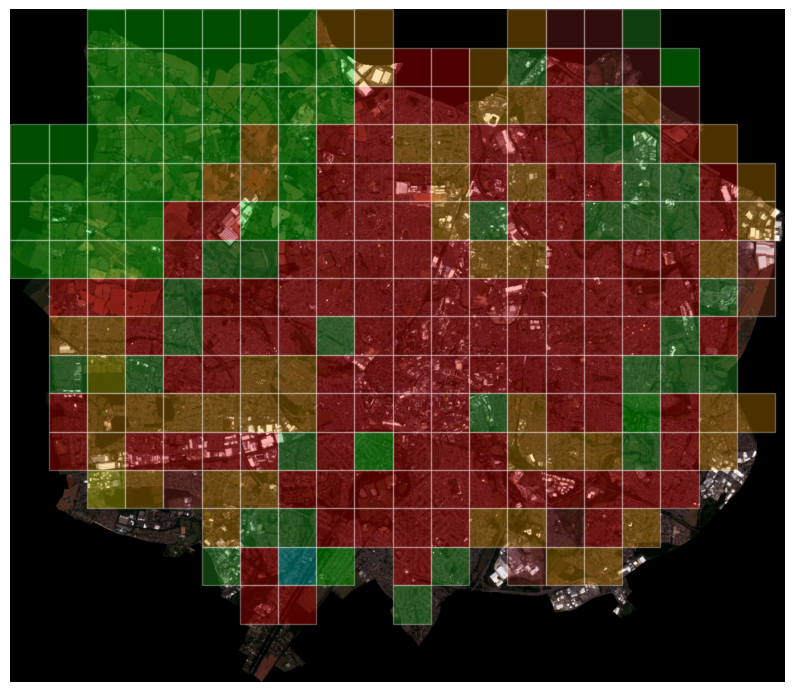

In [539]:
geo_coordinates = [xy(masked_transform, y, x) for (x, y) in coordinates]  # converts pixel to geo-coordinates using tranform
visualise_predictions(masked_image, geo_coordinates, predictions, section_size=64, transform=masked_transform)

## Debug allignment

allignment was slightly off, so experimeted until got this as the best I could get

In [540]:
# alignment was slightly off so adjusted it slightly
# maybe better
x_offset = 0.0042  # move the grid to the right
y_offset = -0.0102  # down
x_scale = 1.0004  # horizontal
y_scale = 1.00006  # vertical

# adjusts coordinates with scaling and offset
adjusted_geo_coordinates = [
    (geo_x * x_scale + x_offset, geo_y * y_scale + y_offset)
    for (geo_x, geo_y) in [xy(masked_transform, y, x) for (x, y) in coordinates]
]

# runs function again with debug offsets
visualise_predictions(masked_image, adjusted_geo_coordinates, predictions, section_size=64, transform=masked_transform)